## <span style='color:black'>This notebook provides a demonstration of the realtime E2E-TTS using TensorflowTTS for Korea (Using KSS dataset)</span>

- Github: https://github.com/TensorSpeech/TensorflowTTS <br>
- Colab for Eng: https://colab.research.google.com/drive/1akxtrLZHKuMiQup00tzO2olCaN-y3KiD?usp=sharing

#### PyCharm clone
!git clone https://github.com/TensorSpeech/TensorFlowTTS.git

#### TensorFlowTTS 폴더로 이동
!cd TensorFlowTTS

#### 현재 디렉토리에 있는 프로젝트를 설치
!pip install .

#### pip upgrade
!git pull
!pip install --upgrade .

#### 독일어 번역자료 설치
!pip install git+https://github.com/repodiac/german_transliterate.git#egg=german_transliterate
!pip install h5py==3.1.0

#### Jupyter Notebook 실행
!Jupyter Notebook

## <span style='color:black'>Load Model</span>

In [1]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

## <span style='color:black'>(a) Tacotron 2</span>

In [15]:
tacotron2 = TFAutoModel.from_pretrained("tensorspeech/tts-tacotron2-kss-ko", name="tacotron2")

## (b) FastSpeech2

In [3]:
fastspeech2 = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech2-kss-ko", name="fastspeech2")

## (c) Multi-band MelGAN

In [4]:
mb_melgan = TFAutoModel.from_pretrained("tensorspeech/tts-mb_melgan-kss-ko", name="mb_melgan")

## Inference
- The first time model run inference will very slow cause by @tf.function.

In [5]:
processor = AutoProcessor.from_pretrained("tensorspeech/tts-tacotron2-kss-ko")

In [6]:
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  input_ids = processor.text_to_sequence(input_text)

  # text2mel part
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  elif text2mel_name == "FASTSPEECH2":
    mel_before, mel_outputs, duration_outputs, _, _ = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH2 are supported on text2mel_name")

  # vocoder part
  if vocoder_name == "MB-MELGAN":
    audio = vocoder_model.inference(mel_outputs)[0, :, 0]
  else:
    raise ValueError("Only MB_MELGAN are supported on vocoder_name")

  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

In [7]:
input_text = "신은 우리의 수학 문제에는 관심이 없다. 신은 다만 경험적으로 통합할 뿐이다."
print('input_text : ', input_text)

input_text :  신은 우리의 수학 문제에는 관심이 없다. 신은 다만 경험적으로 통합할 뿐이다.


## (a) Tacotron2 + MB-MELGAN

In [8]:
# setup window for tacotron2 if you want to try
tacotron2.setup_window(win_front=10, win_back=10)

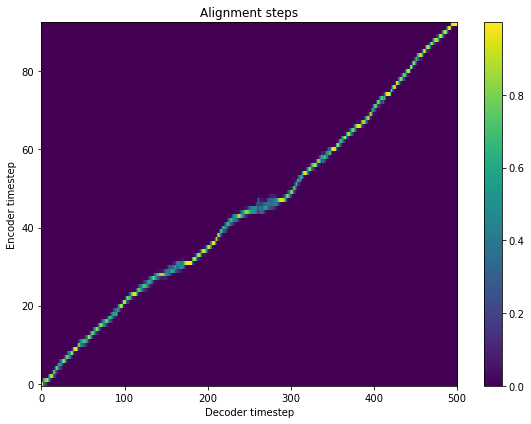

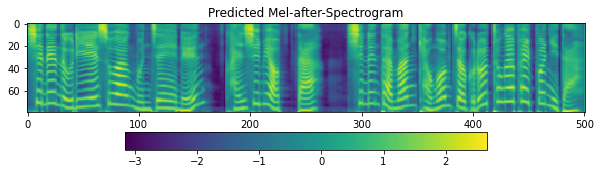

In [9]:
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, mb_melgan, "TACOTRON", "MB-MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)

## (b) FastSpeech2 + MB-MELGAN

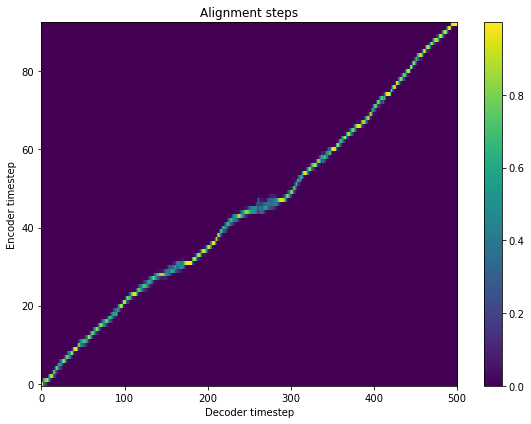

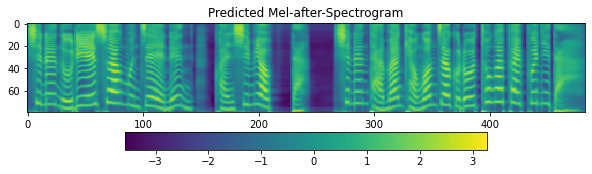

In [10]:
mels, audios = do_synthesis(input_text, fastspeech2, mb_melgan, "FASTSPEECH2", "MB-MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)